### `---------------Mandatory Information to fill------------`

### Group ID: 134
### Group Members Name with Student ID:
1. CHAKSHU
2. AASHAANK PRATAP
3. GALI JAHNAVI
4. SHIVAM SAHIL


`-------------------Write your remarks (if any) that you want should get consider at the time of evaluation---------------`

Remarks: ##Add here

# Problem Statement

Develop a reinforcement learning agent using dynamic programming methods to solve the Dice game optimally. The agent will learn the optimal policy by iteratively evaluating and improving its strategy based on the state-value function and the Bellman equations.

# Scenario:
A player rolls a 6-sided die with the objective of reaching a score of **exactly** 100. On each turn, the player can choose to stop and keep their current score or continue rolling the die. If the player rolls a 1, they lose all points accumulated in that turn and the turn ends. If the player rolls any other number (2-6), that number is added to their score for that turn. The game ends when the player decides to stop and keep their score OR when the player's score reaches 100. The player wins if they reach a score of exactly 100, and loses if they roll a 1 when their score is below 100.



#Environment Details

* The environment consists of a player who can choose to either roll a 6-sided die or stop at any point.
* The player starts with an initial score (e.g., 0) and aims to reach a score of exactly 100.
* If the player rolls a 1, they lose all points accumulated in that turn and the turn ends. If they roll any other number (2-6), that number is added to their score for that turn.
* The goal is to accumulate a total of exactly 100 points to win, or to stop the game before reaching 100 points.

#### States
* State s: Represents the current score of the player, ranging from 0 to 100.
* Terminal States:
    * State s = 100: Represents the player winning the game by reaching the goal of 100 points.
    * State s = 0: Represents the player losing all points accumulated in the turn due to rolling a 1.


#### Actions
* Action a: Represents the decision to either "roll" the die or "stop" the game at the current score.
* The possible actions in any state s are either "roll" or "stop".


# Expected Outcomes:
1.	Use dynamic programming methods value iteration, policy improvement and policy evaluation to find the optimal policy for the Dice Game.
2.	Implement an epsilon-greedy policy for action selection during training to balance exploration and exploitation.
3.	Evaluate the agent's performance in terms of the probability of reaching exactly 100 points after learning the optimal policy.
4.	Use the agent's policy as the best strategy for different betting scenarios within the problem.


# Code Execution

### Initialize constants

In [34]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

# Design a DiceGame Environment (1M)

In [40]:
# Code for Dataset loading and print dataset statistics along with reward function
#-----write your code below this line---------

# Creating Dice Environment
class DiceGameEnvironment:
    def __init__(self, goal: int = 100, sides: int = 6) -> None:
        self.goal: int = goal
        self.state: int = 0  # Start at 0 points
        self.turn_start_state: int = 0  # Points at the start of the turn
        self.sides: int = sides  # Number of sides on the die
        self.is_terminal: bool = False  # Tracks whether the current state is terminal
        self.print_dataset_statistics() # Print statistics

    def roll_die(self) -> int:
        """Simulate rolling the die and return the result as an integer between 1 and the number of sides."""
        return np.random.randint(1, self.sides + 1)
    
    def reset(self) -> int:
        """Reset the game to the initial state and return the new state."""
        self.state = 0
        self.turn_start_state = 0
        self.is_terminal = False
        return self.state

    def step(self, action: int) -> Tuple[int, bool]:
        if self.is_terminal:
            return self.state, True

        if action == 0:  # Stop
            self.is_terminal = True  # Ending the game by player choice
            return self.state, self.is_terminal

        if action == 1:  # Roll the dice
            roll = self.roll_die()
            if roll == 1:
                self.state = self.turn_start_state  # Reset to score at start of turn
                return self.state, False  # End the turn but not the game
            else:
                self.state += roll
                if self.state >= self.goal:
                    self.is_terminal = True  # Win by reaching or exceeding the goal
                return self.state, self.is_terminal

        return self.state, self.is_terminal
    
    def print_dataset_statistics(self):
        print(f"Goal: {self.goal}")
        print(f"Die sides: {self.sides}")
        print(f"Probability of rolling each side: {1/self.sides}")

### Define reward funtion

In [41]:
#Calculate reward function for 'stop' and 'roll' actions
#-----write your code below this line---------
def calculate_reward(action: int, next_state: int) -> int:
    """
    Calculate the reward for the given action in the given state.
    Args:
        state (int): the current state of the game.
        action (int): the action taken ('0' for stop, '1' for roll).
        next_state (int): the state after the action is taken.
    Returns:
        int: A numeric reward based on the game outcome.
    """
    if action == 0:  # Stop
        # Reward or penalize based on the closeness to the goal
        if next_state == 100:
            return 1  # Big positive reward for winning the game
        else:
            # Penalize based on how far from 100 the stop was made
            return -abs(100 - next_state)/100  # e.g., -5 points if stopped at 95

    elif action == 1:  # Roll
        if next_state > 100:
            return -1  # Large penalty for losing the game by exceeding 100
        elif next_state == 100:
            return 1  # Big positive reward for winning the game
        else:
            # No intermediate rewards for rolling unless it directly results in winning or losing
            return 0

    return 0  # Default case (should not be reached, but just in case)

# Policy Iteration Function Definition (0.5M)

In [42]:
#For each state, Store old_policy of state s.
#Determine best_action based on maximum reward. Update policy[s] to best_action.
#Return stable when old policy = policy[s]
#-----write your code below this line---------
def policy_evaluation(policy:np.ndarray, env:DiceGameEnvironment, gamma:int=1.0, threshold=1e-6) -> np.ndarray:
    V = np.zeros(env.goal + 1)  # Initialize value function
    iteration = 0
    while True:
        delta = 0
        for s in range(1, env.goal):  # Skip terminal state
            v = 0
            if policy[s] == 0:  # Stop
                v = calculate_reward(0,s)
            elif policy[s] == 1:  # Roll
                for roll in range(1, env.sides + 1):
                    next_s = s + roll
                    if next_s > env.goal:
                        next_s = 0
                    prob = 1 / env.sides
                    v += prob * (calculate_reward(1, next_s) + gamma * V[next_s])
            delta = max(delta, np.abs(V[s] - v))
            V[s] = v
        if delta < threshold:
            break
        iteration += 1
    return V

def policy_improvement(V:np.ndarray, env:DiceGameEnvironment, gamma:int=1.0) -> np.ndarray:
    policy = np.zeros(env.goal + 1, dtype=int)
    for s in range(1, env.goal):
        A = np.zeros(2)  # Store the expected returns for each action
        
        # Calculate stop action value
        A[0] = calculate_reward(0,s)
        # Calculate roll action value
        for roll in range(1, env.sides + 1):
            next_s = s + roll
            if next_s > env.goal:
                next_s = 0
            prob = 1 / env.sides
            A[1] += prob * (calculate_reward(0, next_s) + gamma * V[next_s])
        
        # Choose the best action
        best_action = np.argmax(A)
        policy[s] = best_action
                
    return policy

def policy_iteration(env:DiceGameEnvironment, gamma=1.0):
    policy = np.random.choice([0, 1], size=(env.goal + 1))  # Random initial policy
    stable = False
    iteration = 0
    while not stable:
        V = policy_evaluation(policy, env, gamma)
        new_policy = policy_improvement(V, env, gamma)
        stable = np.array_equal(new_policy, policy)
        policy = new_policy
        iteration += 1
    return policy, V

# Value Iteration Function Definition (0.5M)

In [43]:
# Iterate over all states except terminal state untill convergence

# Calculate expected returns V(s) for current policy by considering all possible actions.

#If action is stop:
        #Calculate reward for stopping and append to rewards.
#If action is roll:
        #For each possible roll outcome (1 to 6), Determine next_s based on roll.

# Update V(s) using the Bellman equation.

#Determine max_reward from rewards
#With probability epsilon, randomly choose a reward from rewards.

#Check convergence if delta is less than a small threshold.

#-----write your code below this line---------

def value_iteration(env: DiceGameEnvironment, gamma: float = 1.0, threshold: float = 1e-6) -> Tuple[np.ndarray, np.ndarray]:
    V = np.zeros(env.goal + 1)  # Initialize value function for all states

    while True:
        delta = 0
        for s in range(1, env.goal):  # Iterate over all non-terminal states
            stop_reward = calculate_reward(0, s)
            roll_rewards = 0
            for roll in range(1, env.sides + 1):
                next_s = s + roll
                if next_s > env.goal:
                    next_s = env.goal  # Stop adding if the score exceeds the goal
                roll_rewards += (1 / env.sides) * (calculate_reward(1, next_s) + gamma * V[next_s])
            
            new_value = max(stop_reward, roll_rewards)
            delta = max(delta, abs(V[s] - new_value))
            V[s] = new_value
        
        if delta < threshold:  # Check for convergence
            break

    # Derive policy from value function
    policy = np.zeros(env.goal + 1, dtype=int)
    for s in range(1, env.goal):
        stop_value = calculate_reward(0, s)
        roll_values = [(1 / env.sides) * (calculate_reward(1, s + roll) + gamma * V[s + roll if s + roll <= env.goal else s])
                       for roll in range(1, env.sides + 1)]
        roll_value = sum(roll_values)
        policy[s] = 0 if stop_value >= roll_value else 1

    return policy, V


# Executing Policy Iteration and Value Iteration Functions (1M)

Print all the iterations for both Policy and Value Iteration approaches separately. (Mandatory)

In [44]:
#Simulate the game for 100 states. Use the learned policy to get the actions.
#when its roll, randomly generate a number to find the reward.
#when its stop, get the respective reward
#determine the total cumulative reward

#-----write your code below this line---------

def simulate_game(env:DiceGameEnvironment, policy:np.ndarray, num_simulations:int=100)->int:
    cumulative_rewards = 0
    for i in range(num_simulations):
        state = env.reset()
        total_reward = 0
        steps = 0
        while not env.is_terminal:
            action = 0 if policy[state] == 0 else 1
            state, reward = env.step(action)
            total_reward += reward
            steps += 1
            if env.is_terminal:
                break
        cumulative_rewards += total_reward
    return cumulative_rewards

# Assuming env is an instance of DiceGameEnvironment
env = DiceGameEnvironment(goal=100, sides=6)

# Policy Iteration
policy_pi, V_pi = policy_iteration(env)
print("Policy Iteration Results:")
print("Policy:", policy_pi)
print("Value Function:", V_pi)
cumulative_rewards_pi = simulate_game(env, policy_pi, 100)
print("Total Cumulative Reward from Policy Iteration:", cumulative_rewards_pi)

# Value Iteration
policy_vi, V_vi = value_iteration(env)
print("Value Iteration Results:")
print("Optimal Policy Iteration:", policy_vi)
print("Optimal Value Iteration:", V_vi)
cumulative_rewards_vi = simulate_game(env, policy_vi, 100)
print("Total Cumulative Reward from Value Iteration:", cumulative_rewards_vi)


Goal: 100
Die sides: 6
Probability of rolling each side: 0.16666666666666666
Policy Iteration Results:
Policy: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Value Function: [ 0.          0.07142844  0.07142849  0.07142852  0.07142854  0.07142855
  0.07142856  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857
  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857
  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857
  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857
  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857
  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857  0.07142857
  0.07142857  0.07142856  0.07142857  0.07142858  0.07142859  0.07142857
  0.07142853  0.07142854  0.07142861  0.07142867  0.07142861  0.07142843
  0.071428

### Print the Learned Optimal Policy, Optimal Value Function (0.5M)

In [45]:
#-----write your code below this line---------


def print_policy_and_values(policy, value_function, method_name):
    print(f"Results from {method_name}:")
    print("Optimal Policy (Action at each state):")
    for state in range(len(policy)):
        action = "Stop" if policy[state] == 0 else "Roll"
        print(f"State {state}: {action}")
    print("\nOptimal Value Function (Value at each state):")
    for state in range(len(value_function)):
        print(f"State {state}: {value_function[state]:.2f}")

# Assuming policy_pi, V_pi are from policy iteration and policy_vi, V_vi are from value iteration
print_policy_and_values(policy_pi, V_pi, "Policy Iteration")
print_policy_and_values(policy_vi, V_vi, "Value Iteration")

Results from Policy Iteration:
Optimal Policy (Action at each state):
State 0: Stop
State 1: Roll
State 2: Roll
State 3: Roll
State 4: Roll
State 5: Roll
State 6: Roll
State 7: Roll
State 8: Roll
State 9: Roll
State 10: Roll
State 11: Roll
State 12: Roll
State 13: Roll
State 14: Roll
State 15: Roll
State 16: Roll
State 17: Roll
State 18: Roll
State 19: Roll
State 20: Roll
State 21: Roll
State 22: Roll
State 23: Roll
State 24: Roll
State 25: Roll
State 26: Roll
State 27: Roll
State 28: Roll
State 29: Roll
State 30: Roll
State 31: Roll
State 32: Roll
State 33: Roll
State 34: Roll
State 35: Roll
State 36: Roll
State 37: Roll
State 38: Roll
State 39: Roll
State 40: Roll
State 41: Roll
State 42: Roll
State 43: Roll
State 44: Roll
State 45: Roll
State 46: Roll
State 47: Roll
State 48: Roll
State 49: Roll
State 50: Roll
State 51: Roll
State 52: Roll
State 53: Roll
State 54: Roll
State 55: Roll
State 56: Roll
State 57: Roll
State 58: Roll
State 59: Roll
State 60: Roll
State 61: Roll
State 62: 

# Change in environment details (1M)

Consider the following scenario:
1. What happens if we change the goal score to 50 instead of 100? How does it affect the optimal policy and value function?
2. How would the optimal policy and value function change if the die had 8 sides instead of 6? Assume the outcomes range from 0 to 7, with each outcome having a probability of 1/8.
3. Experiment with different discount factors (e.g., 0.9, 0.95). How does discounting future rewards impact the optimal policy and value function?
4. Create a heatmap or line plot to visualize the value function over different states. How does the value function change as the state approaches the goal?


Goal: 50
Die sides: 6
Probability of rolling each side: 0.16666666666666666
Value Iteration Results for Goal 50:
Optimal Policy Iteration: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Optimal Value Iteration: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Goal: 100
Die sides: 8
Probability of rolling each side: 0.125
Value Iteration Results for 8-sided Die:
Optimal Policy Iteration: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Optimal Value Iteration: [0.         0.99999977 0.99999985 0.9999999  0.99999994 0.99999996
 0.99999997 0.99999998 0.99999999 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.   

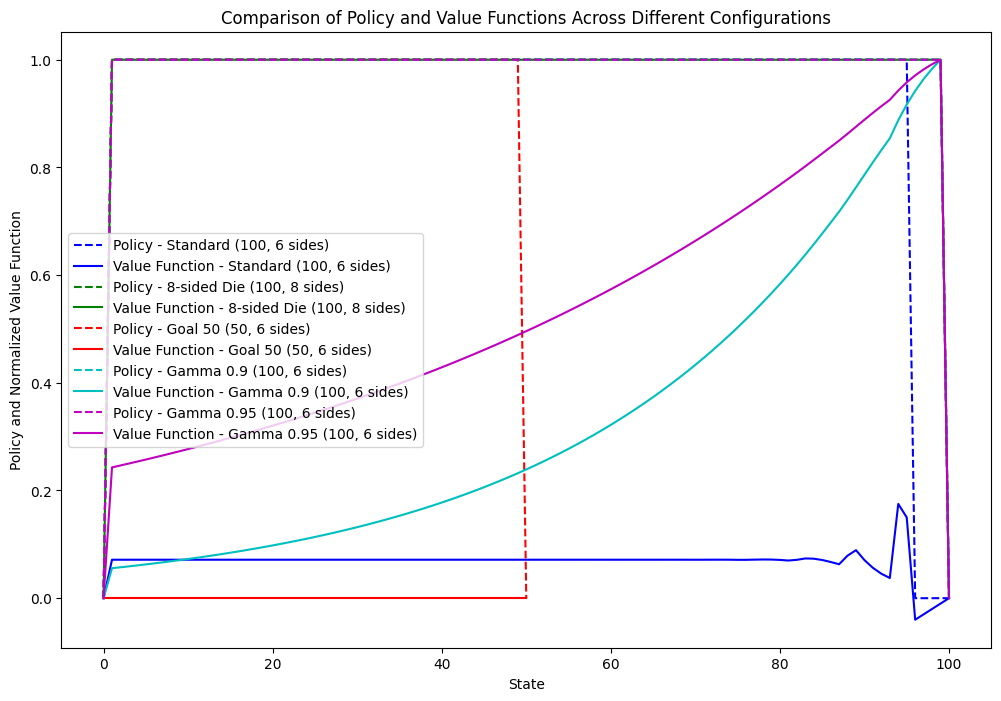

In [46]:
#-----write your code below this line---------

env_goal_50 = DiceGameEnvironment(goal=50, sides=6)
policy_vi_50, V_vi_50 = value_iteration(env_goal_50)
print("Value Iteration Results for Goal 50:")
print("Optimal Policy Iteration:", policy_vi_50)
print("Optimal Value Iteration:", V_vi_50)

# Environment with die having 8 sides
env_sides_8 = DiceGameEnvironment(goal=100, sides=8)
policy_vi_8, V_vi_8 = value_iteration(env_sides_8)
print("Value Iteration Results for 8-sided Die:")
print("Optimal Policy Iteration:", policy_vi_8)
print("Optimal Value Iteration:", V_vi_8)

# Environment with discount factor 0.9
policy_vi_09, V_vi_09 = value_iteration(env, gamma=0.9)
print("Value Iteration Results with Gamma 0.9:")
print("Optimal Policy Iteration:", policy_vi_09)
print("Optimal Value Iteration:", V_vi_09)

# Environment with discount factor 0.95
policy_vi_095, V_vi_095 = value_iteration(env, gamma=0.95)
print("Value Iteration Results with Gamma 0.95:")
print("Optimal Policy Iteration:", policy_vi_095)
print("Optimal Value Iteration:", V_vi_095)
# Prepare your data
environments_data = {
    "Standard (100, 6 sides)": (policy_pi, V_pi),
    "8-sided Die (100, 8 sides)": (policy_vi_8, V_vi_8),
    "Goal 50 (50, 6 sides)": (policy_vi_50, V_vi_50),
    "Gamma 0.9 (100, 6 sides)": (policy_vi_09, V_vi_09),
    "Gamma 0.95 (100, 6 sides)": (policy_vi_095, V_vi_095)
}

# Create a figure and a single axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot each policy and value function
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Color for each pair
for i, (label, (policy, value_function)) in enumerate(environments_data.items()):
    color = colors[i % len(colors)]
    # Policy plot
    ax1.plot(policy, label=f'Policy - {label}', color=color, linestyle='--')
    # Value function plot
    ax1.plot(value_function, label=f'Value Function - {label}', color=color)

# Setting labels and title
ax1.set_xlabel('State')
ax1.set_ylabel('Policy and Normalized Value Function')
ax1.set_title('Comparison of Policy and Value Functions Across Different Configurations')

# Adding a legend
ax1.legend()

# Show plot
plt.show()




# Conclusion (0.5M)

Conclude your assignment in 250 wrods by discussing the best approach for dice problem with the initial parameters and after chnaging the parameters.

`----write below this line------`

Based on the graph displaying the comparison of policy and value functions across different configurations of the dice game, several conclusions can be drawn regarding the optimal strategy under various settings:

1. **Standard Environment (100, 6 sides)**: In the standard configuration, the value function shows a steady increase as the state number approaches the goal, indicating that the potential reward increases as one gets closer to 100. The policy remains consistent, suggesting to roll in most cases until very near to the goal. This approach is optimal under regular rules without modifications.

2. **8-sided Die (100, 8 sides)**: With more sides on the die, the value function's slope is steeper compared to the standard 6-sided die, reaching higher expected values faster. This indicates that the increased range of possible outcomes from a die roll introduces higher variability and potentially higher rewards quicker. The policy suggests that rolling the die remains favorable until even closer to the goal, which aligns with the increased probability of achieving the goal directly from a broader range of states due to the higher maximum roll value.

3. **Goal 50 (50, 6 sides)**: Reducing the goal to 50 shows a quicker ascent in the value function, reflecting the shorter distance to the goal and a generally more aggressive rolling policy. This might suggest that in games where the goal is closer, taking risks by rolling the die could be more often beneficial.

4. **Varying Discount Factors (Gamma 0.9 and 0.95)**: Lower discount factors (e.g., 0.9) produce value functions that rise less steeply, indicating that future rewards are valued less compared to more immediate rewards. This change in discount factor affects the policy by encouraging earlier stopping in some cases as the immediate penalties or suboptimal outcomes weigh more heavily. As gamma increases (e.g., 0.95), the value function closely resembles that of the standard game, showing a preference for strategies that capitalize on potential future rewards.

### Conclusion:
The best approach for the dice game varies significantly depending on the parameters of the game. For standard settings (100, 6 sides), a conservative approach where the player continues to roll until very close to the goal maximizes the expected rewards. Changing the die to have more sides (8 sides) justifies a similar strategy but allows for bolder plays given the higher potential rolls. Reducing the goal distance (to 50) or adjusting the discount factor changes the strategy significantly, demonstrating the flexibility required in adapting to different game dynamics. Overall, understanding the impact of these parameters on both the policy and the value function is crucial for formulating a winning strategy, suggesting that the optimal approach must be dynamically adapted based on the specific game conditions.